# Introduction to MRS processing with Suspect

Welcome to the first in our series of tutorials in how to use Suspect for working with MR spectroscopy data. In this introduction, we will present some of the basic features of Suspect while in subsequent tutorials we will explore various parts of the processing pipeline in more detail.

The first thing is to import the `suspect` package. We will also import the `pyplot` module from Matplotlib, which we will use for plotting our data, and we use some Jupyter "magic" to cause all plots to be rendered inline with the text in the notebook.

In [ ]:
import suspect
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Let's get started by loading some MRS data. Suspect currently supports various different data formats including Siemens DICOM, RDA and TWIX and Philips SDAT. GE P files are not yet supported but should be soon. The Suspect repository on Github contains a number of example data files and we will be using those throughout this tutorial series, so you can follow along if you like. If you are using the OpenMRSLab Docker image (which we use to write all these tutorials) then you will find this sample data in the folder at `/home/jovyan/suspect/tests/test_data/`. We are going to start with an RDA file for a short echo time single voxel PRESS sequence.

In [2]:
data = suspect.io.load_rda("/home/jovyan/suspect/tests/test_data/siemens/SVS_30.rda")
print(data)

<MRSData instance f0=123.234655MHz TE=30.0ms dt=0.833ms>


When we print the data object we just loaded we see that it is an instance of the `MRSData` class, and we also get some other information about the acquisition sequence such as the field strength and echo time. The `MRSData` class stores time domain spectroscopy data and is at the core of the Suspect package. It is a subclass of `numpy.ndarray` which means it has all the standard properties, as well as additional MRS specific ones. To learn more about the `MRSData` class and all its functions and properties, check out the [MRSData API Reference](../mrs_data_api.rst)

In [3]:
print(data.shape)
print(data.f0)
print(data.dt)
print(data.sw)

(1024,)
123.234655
0.000833
1200.4801920768307


Now that we have some data loaded, we want to plot it to see what it looks like. As an `ndarray` subclass, `MRSData` is fully compatible with the standard Matplotlib plotting library so displaying our FID is as simple as:

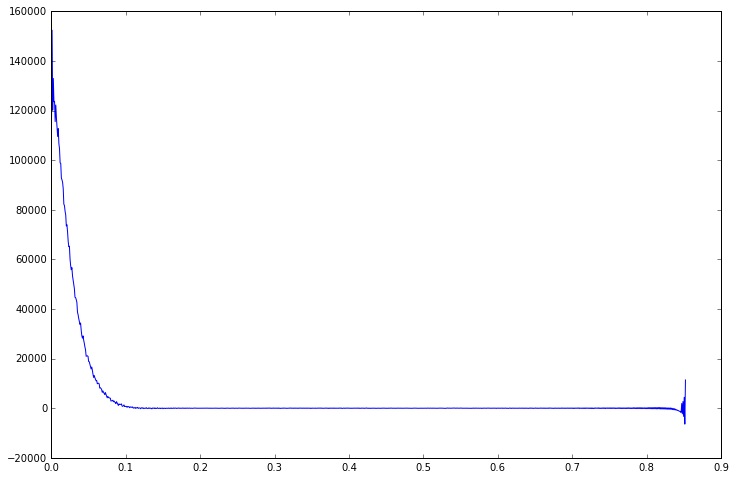

In [4]:
plt.plot(data.time_axis(), data.real)

Note that the `MRSData` object has a `time_axis()` method which gives us the time at which each FID point was acquired. There are similar methods in the frequency domain to give us the axis in Hz or PPM. To obtain the spectrum from the FID we can apply the Fourier transform directly, or just use the helper `spectrum()` method provided by `MRSData`.

(10, -1)

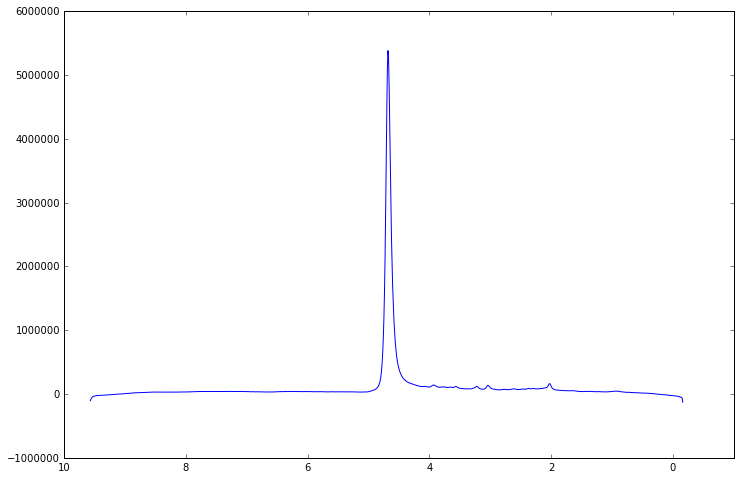

In [5]:
plt.plot(data.frequency_axis_ppm(), data.spectrum().real)
# reverse the limits on the x-axis so that ppm runs from right to left
plt.xlim([10, -1])

Looking back at the time domain plot we can see that there is a spurious signal which appears at the end of the acquisition window. This kind of artefact can distort the spectrum and cause problems in subsequent processing. For example the end of the FID is often considered to be pure noise, which is used in assessing SNR and these false signals can affect this analysis.

Fortunately we can get rid of this artefact by apodising our data, that is applying a windowing function in the time domain. The `scipy.signal` package provides a huge array of different windowing functions, in our case we will be using the Tukey window as this allows us to leave the first half of the signal completely unaffected and only suppress the signal close to the artefact region.

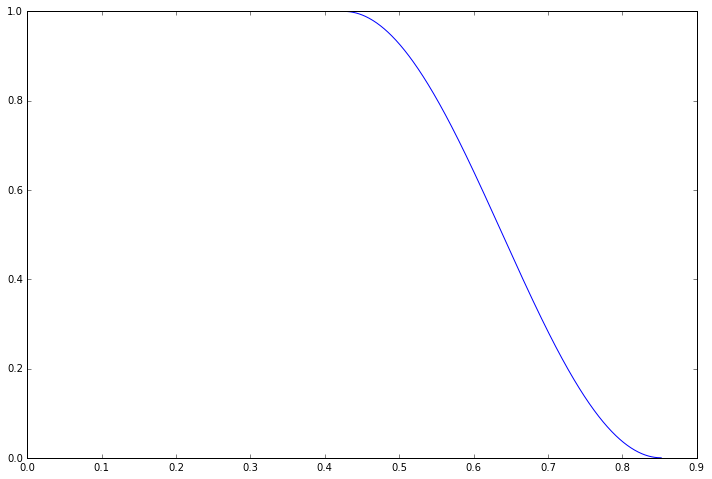

In [6]:
import scipy.signal
# scipy.signal produces symmetric windows so only take the second half
window = scipy.signal.tukey(data.np * 2)[data.np:]
plt.plot(data.time_axis(), window)

Applying the window to our FID data is as simple as multiplying the two objects together. NumPy will multiply the two arrays componentwise and return the result as a new `MRSData` object, copying all the parameters from the original `data` object, so that the new object keeps all the essential MRS parameters and methods.

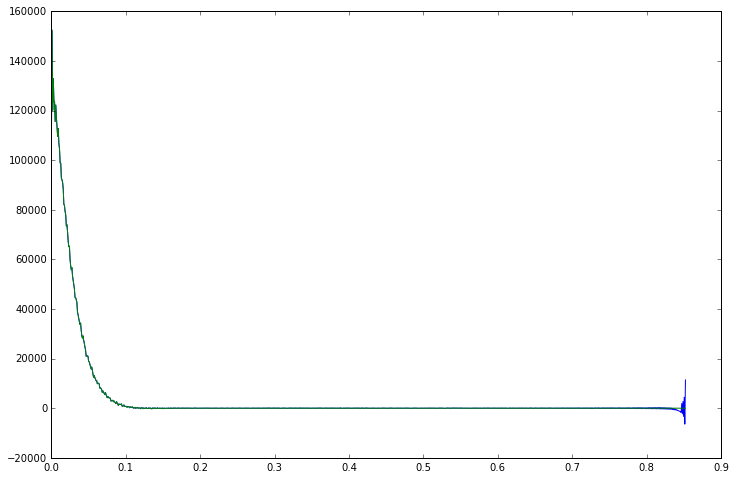

In [7]:
windowed_data = window * data
plt.plot(data.time_axis(), data.real)
plt.plot(windowed_data.time_axis(), windowed_data.real)

So that concludes our first look at the Suspect library. We have learnt about the `MRSData` class, how to load MRS data from a file and plot it, in the time and frequency domains, and seen a simple example of removing an artefact through apodisation. In the following tutorials, we will learn how to use Suspect to do more advanced data processing, including working with raw data, channel combination, B0 drift correction and water suppression.